In [9]:
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from pyod.models.knn import KNN

%matplotlib inline

In [3]:
#load data
DroneData = pd.read_csv('./DroneData/SP Cup 2020/IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')


In [68]:
def extract_normalization_params(DroneData, params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    imuParamsData = DroneData.loc[:, params]
    normImuData = (imuParamsData - imuParamsData.mean())/imuParamsData.std()
    return normImuData, imuParamsData.mean(), imuParamsData.std()

def normalize_test_data(Data, mean, std, params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']):
    imuParamsData = Data.loc[:, params]
    normImuData = (imuParamsData - mean)/std
    return normImuData

def find_theta_score(Data,dims=1):
    """
    Converts n dimensions to a lower dimensional score,
    for easier visualization
    """
    pca = PCA(n_components=1)
    pca.fit(Data[['x','y','z','w']])
    theta_scorea = pca.transform(Data[['x','y','z','w']])
    
    pca.fit(Data[['x.1','y.1','z.1']])
    theta_scoreb = pca.transform(Data[['x.1','y.1','z.1']])
    
    pca.fit(Data[['x.2','y.2','z.2']])
    theta_scorec = pca.transform(Data[['x.2','y.2','z.2']])
    
    return np.array([theta_scorea, theta_scoreb, theta_scorec]).T[0]

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)

def plot_anomalies_in_2D(z2_score, anomalyPrediction):
    """
    plots z1 and z2 as a scatter plot on x and y axes respectively,
    with anomalies as red points and normal instances as blue
    """
    for i in range(len(z2_score.T)):
        if anomalyPrediction[i]:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'r')
        else:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'b')
            
def generate_metrics(anomalyPrediction,testDataLabel):
    """
    generates accuracy and detection rate metrics, takes
    into input the prediction and the label column of the data
    lengths of the two vectors must match
    """
    actual_value = testDataLabel == 4
    #how many readings match
    N_set = anomalyPrediction == actual_value
    
    accuracy = sum(N_set)/len(testDataLabel)
    detection_rate = sum(anomalyPrediction)/sum(actual_value)
    false_positives = sum(np.logical_and((np.invert(actual_value)), anomalyPrediction))/len(testDataLabel)
    false_negatives = sum(np.logical_and(actual_value, np.invert(anomalyPrediction)))/len(testDataLabel)
    print('accuracy = ', accuracy,',detection rate =', detection_rate,'\nfalse positive rate = '
          ,false_positives,',false negative rate =',false_negatives)

In [56]:
#fit mean and std for normalization

normImuData, mean , std = extract_normalization_params(DroneData)
trainData = normImuData

In [74]:
#import new test data here
testData1 = normalize_test_data(pd.concat([pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-12/_slash_mavros_slash_imu_slash_data.csv'),
                                         pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-49/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-33-26/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-08/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-43/_slash_mavros_slash_imu_slash_data.csv')]), mean, std)

testData2 = normalize_test_data(pd.read_csv('DroneData/SP Cup 2020/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-37-25/_slash_mavros_slash_imu_slash_data.csv'), mean, std)
z_score1 = find_theta_score(testData1)
z_score2 = find_theta_score(testData2)

array([[-9.62201759, -0.57762155,  4.87969582],
       [-9.61102141,  0.68295585,  4.08533162],
       [-9.61049495, -0.22224697,  3.50001053],
       ...,
       [ 1.76338883,  0.26252878,  1.95997151],
       [ 1.53728956, -1.14343458,  3.79866264],
       [ 1.49019306,  0.05048868,  4.08916961]])

/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


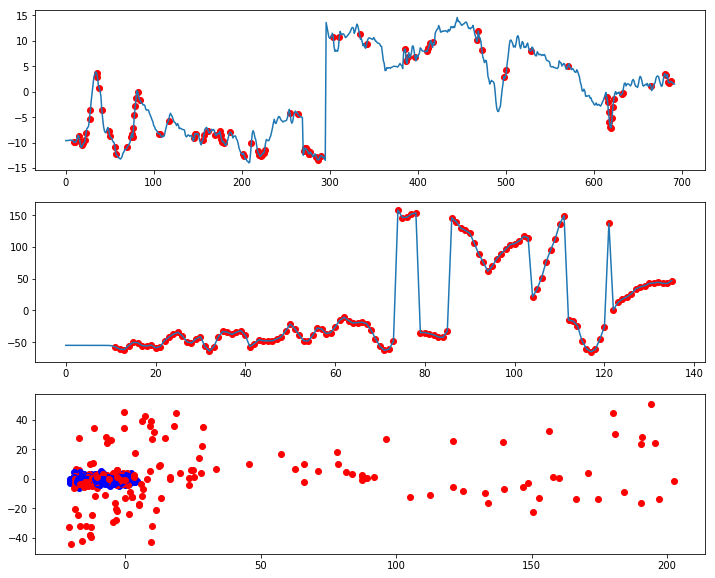

In [113]:
# using IsoFo

#add your algos in this very format pls

from sklearn.ensemble import IsolationForest

#fit isofo model
clf = IsolationForest(n_estimators=1000,contamination=0.001) #contamination parameter specifies the level of contamination in training data
clf.fit(trainData)

#predict anomalies
tempanomalyPrediction1 = clf.predict(testData1)
anomalyPrediction1 = tempanomalyPrediction1 == -1

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature
plt.figure(figsize = (12,10))
plt.subplot(3,1,1)
plot_anomalies_in_1D(z_score1.T[0], anomalyPrediction1)

tempanomalyPrediction2 = clf.predict(testData2)
anomalyPrediction2 = tempanomalyPrediction2 == -1
plt.subplot(3,1,2)
plot_anomalies_in_1D(z_score2.T[0], anomalyPrediction2)

z2_score = find_theta_score(pd.concat([testData1, testData2],ignore_index = True),2)
plt.subplot(3,1,3)
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPrediction1, anomalyPrediction2]))

In [17]:
#left blank intentionally

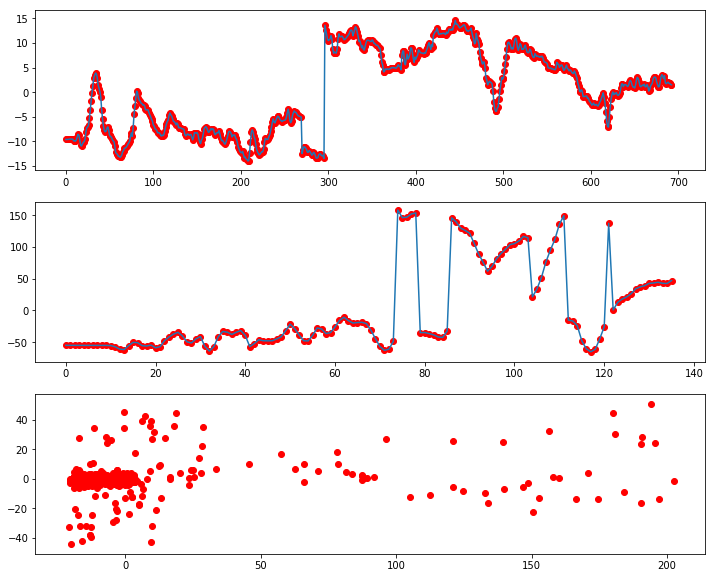

In [110]:
#using one class SVM

from sklearn.svm import OneClassSVM

#fit model
oneclass = OneClassSVM(kernel='linear')
oneclass.fit(trainData)

#predict anomalies
tempanomalyPredictionSVM1 = oneclass.predict(testData1)
anomalyPredictionSVM1 = tempanomalyPredictionSVM1 == -1

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature
plt.figure(figsize = (12,10))
plt.subplot(3,1,1)
plot_anomalies_in_1D(z_score1.T[0], anomalyPredictionSVM1)

tempanomalyPredictionSVM2 = oneclass.predict(testData2)
anomalyPredictionSVM2 = tempanomalyPredictionSVM2 == -1
plt.subplot(3,1,2)
plot_anomalies_in_1D(z_score2.T[0], anomalyPredictionSVM2)
plt.subplot(3,1,3)
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPredictionSVM1, anomalyPredictionSVM2]))

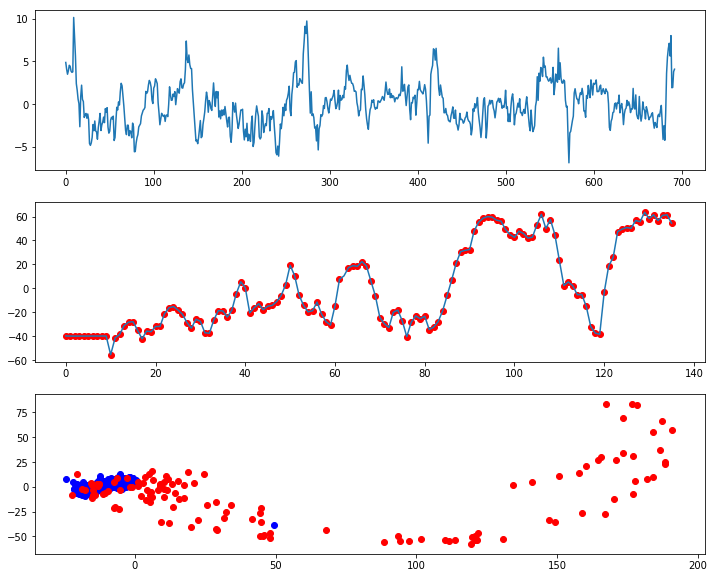

In [98]:
#using KNN
from pyod.models.knn import KNN

params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']
#fit model
lof = KNN()

z = find_theta_score(trainData)

lof.fit(z)
scores = lof.decision_scores_
test_scores1 = lof.decision_function(find_theta_score(testData1,2))
test_scores2 = lof.decision_function(find_theta_score(testData2,2))

thres = scores.mean()+18*scores.std()
anomalyPredictionLOF = test_scores1 > thres
anomalyPredictionLOF1 = test_scores2 > thres
plt.figure(figsize = (12,10))
plt.subplot(3,1,1)
plot_anomalies_in_1D(z_score1.T[2], anomalyPredictionLOF)
plt.subplot(3,1,2)
plot_anomalies_in_1D(z_score2.T[2], anomalyPredictionLOF1)
plt.subplot(3,1,3)
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPredictionLOF,anomalyPredictionLOF1]))


# IMAGE DATA TESTING HAS BEEN MIGRATED TO TestingImage.ipynb

In [114]:
scores

array([0.05572274, 0.0364773 , 0.02350093, 0.02350093, 0.03187056,
       0.00959646, 0.01011299, 0.01182982, 0.0124153 , 0.01194199,
       0.03374709, 0.01257665, 0.0124153 , 0.06023383, 0.01400812,
       0.01061591, 0.02375709, 0.02596205, 0.01484924, 0.02337536,
       0.04584505, 0.01209716, 0.03301402, 0.01789897, 0.01291019,
       0.01277605, 0.01251104, 0.02100336, 0.01238533, 0.01070521,
       0.01472739, 0.01433582, 0.01274516, 0.01453527, 0.01103245,
       0.03504554, 0.01484924, 0.01549922, 0.06718763, 0.01749605,
       0.01429602, 0.07738188, 0.04188698, 0.02276158, 0.02545992,
       0.04328655, 0.01392979, 0.01092253, 0.01369411, 0.01738801,
       0.04382906, 0.02629664, 0.07125096, 0.04449393, 0.05489486,
       0.25803498, 0.53505177, 0.28276427, 0.3872929 , 0.24833686,
       0.22562766, 0.22557787, 0.21318706, 0.23205828, 0.23505545,
       0.24833686, 0.2149276 , 0.20652283, 0.17042611, 0.15687976,
       0.23766389, 0.14941841, 0.28341458, 0.22485148, 0.24004